# Fixed and smooth effects in location regression

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os 

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

rng = np.random.default_rng(42)

# Load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

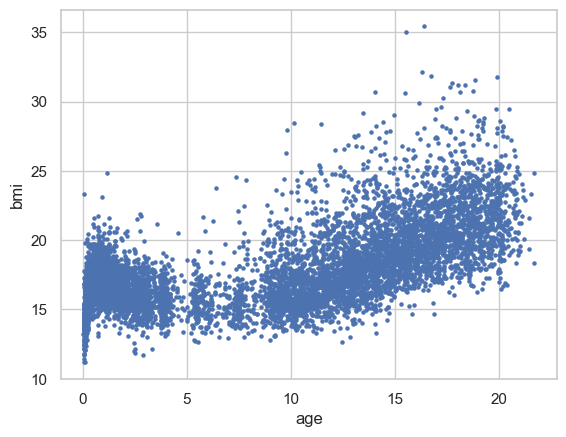

In [2]:
# Plot the data
sns.set_theme(style="whitegrid")
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [4]:
# Define a model with intercept 
# Set up design matrix 
X = tiger.Obs(name="X_loc", intercept=True)
X.smooth(data=df["age"].to_numpy())
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
X.center()

# Fixed coefficents 
# Set up beta_fixed hyperparameters 
beta_fixed_loc = tiger.Hyper(0.0, name="beta_fixed_loc")
beta_fixed_scale = tiger.Hyper(100.0, name="beta_fixed_scale")

# Set up parameters
beta_fixed_dist = tiger.Dist(tfjd.Normal, loc=beta_fixed_loc, scale=beta_fixed_scale)
beta_fixed = tiger.Param(value=df["bmi"].to_numpy().mean(), distribution=beta_fixed_dist, name="beta_fixed")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
tau2_a = tiger.Hyper(1.0, name="tau2_a")
tau2_b = tiger.Hyper(0.00005, name="tau2_b")
tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau2_a, scale=tau2_b)
tau2 = tiger.Param(value=jnp.array([1.0]), distribution=tau2_dist, param_space="positive", name="tau2")

# Smooth coefficients
# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
beta_smooth_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[0]), name="beta_smooth_loc")

# Define the penalty matrix 
pen = tiger.Hyper(X.smooth_pen_mat_cent[0], name="beta_smooth_pen")

# Set up parameters
beta_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=beta_smooth_loc, var=tau2, pen=pen)
beta_smooth = tiger.Param(value=np.zeros(X.smooth_dim_cent[0]), distribution=beta_smooth_dist, name="beta_smooth")
# ----

# Set up the linear predictor
lpred = tiger.Lpred(obs=X, beta_fixed=beta_fixed, beta_smooth=beta_smooth)

# Set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

## Test log-prob and setup the graph 

In [5]:
m.log_prob

Array(-23843.072, dtype=float32)

In [6]:
m.log_prior

Array(-37.034946, dtype=float32)

In [7]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [8]:
graph.logprob()

Array(-23843.072, dtype=float32)

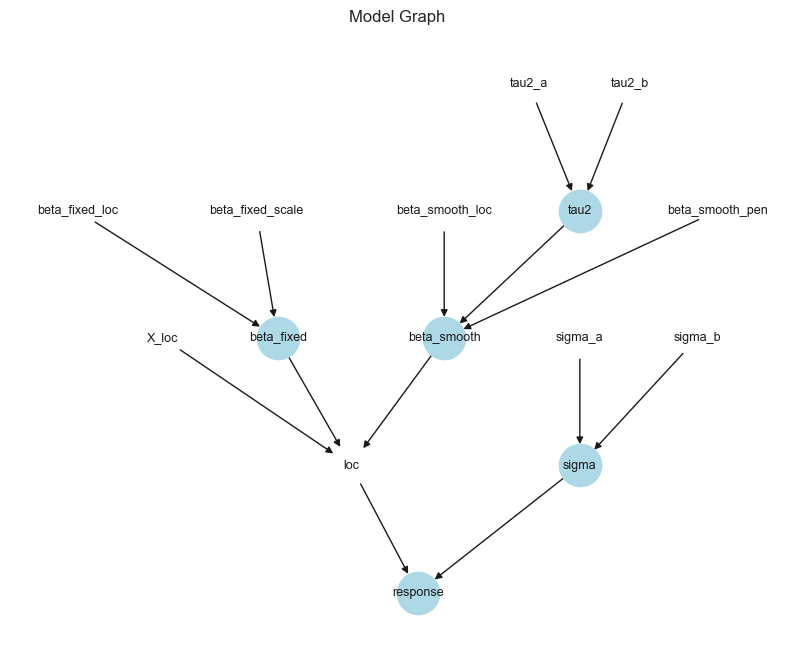

In [9]:
graph.visualize_graph()

## Test functions of Bbvi

In [10]:
import tigerpy.distributions.mvn as mvn
from tigerpy.bbvi.transform import(
    log_cholesky_parametrization_to_tril
)

In [11]:
q = bbvi.Bbvi(graph=graph)
key = jax.random.PRNGKey(27)
key, *subkeys = jax.random.split(key, len(q.init_var_params)+1)

In [12]:
loc_beta_fixed, log_chol_beta_fixed = q.init_var_params["beta_fixed"]["loc"], q.init_var_params["beta_fixed"]["log_cholesky_prec"]
loc_beta_smooth, log_chol_beta_smooth = q.init_var_params["beta_smooth"]["loc"], q.init_var_params["beta_smooth"]["log_cholesky_prec"]
loc_sigma, log_chol_sigma = q.init_var_params["sigma"]["loc"], q.init_var_params["sigma"]["log_cholesky_prec"]
loc_tau2, log_chol_tau2 = q.init_var_params["tau2"]["loc"], q.init_var_params["tau2"]["log_cholesky_prec"]
lower_tri_beta_fixed = log_cholesky_parametrization_to_tril(log_chol_beta_fixed, d=loc_beta_fixed.shape[0])
lower_tri_beta_smooth = log_cholesky_parametrization_to_tril(log_chol_beta_smooth, d=loc_beta_smooth.shape[0])
lower_tri_sigma = log_cholesky_parametrization_to_tril(log_chol_sigma, d=loc_sigma.shape[0])
lower_tri_tau2 = log_cholesky_parametrization_to_tril(log_chol_tau2, d=loc_tau2.shape[0])

In [13]:
samples_beta_fixed = mvn.mvn_precision_chol_sample(loc=loc_beta_fixed, precision_matrix_chol=lower_tri_beta_fixed, key=subkeys[0], S=64)
samples_beta_smooth = mvn.mvn_precision_chol_sample(loc=loc_beta_smooth, precision_matrix_chol=lower_tri_beta_smooth, key=subkeys[1], S=64)
samples_sigma = mvn.mvn_precision_chol_sample(loc=loc_sigma, precision_matrix_chol=lower_tri_sigma, key=subkeys[2], S=64)
samples_tau2 = mvn.mvn_precision_chol_sample(loc=loc_tau2, precision_matrix_chol=lower_tri_tau2, key=subkeys[3], S=64)

In [14]:
test_samples = {"beta_fixed": samples_beta_fixed,
                "beta_smooth": samples_beta_smooth,
                "sigma": jnp.exp(samples_sigma),
                "tau2": jnp.exp(samples_tau2)}

In [15]:
batch_idx = jax.random.choice(key, q.num_obs, (32,), replace=False)

In [16]:
data_new = jax.tree_map(lambda x: x[batch_idx], q.data)

In [17]:
q.mc_logprob(data_new,  test_samples, q.num_obs)

Array(-24176.941, dtype=float32)

In [18]:
q.lower_bound(q.init_var_params, 
              data_new,
              num_obs=q.num_obs,
              num_var_samples=64,
              key=key)

Array(24050.008, dtype=float32)

## Inference with Bbvi

In [19]:
q = bbvi.Bbvi(graph=graph)

In [20]:
q.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=1,
           batch_size=1024,
           num_var_samples=64,
           chunk_size=50,
           epochs=500)

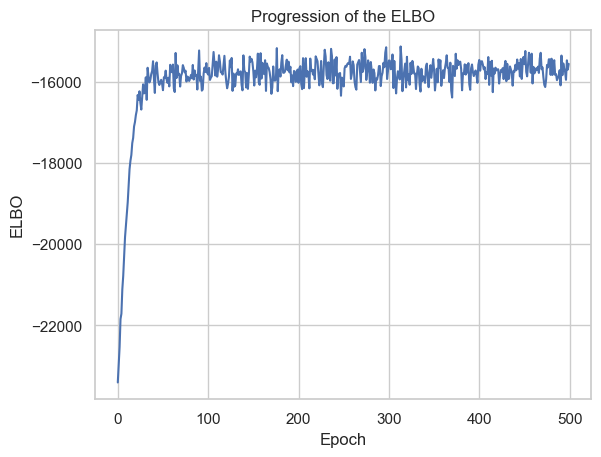

In [21]:
q.plot_elbo()

## Visualize the regression line 

In [22]:
b = q.trans_var_params["beta_smooth"]["loc"]
b

Array([-2.5855906 , -2.6000314 , -2.1633782 , -2.2417846 , -2.3415973 ,
       -2.105227  , -1.7078367 , -1.4104087 , -1.1543965 , -0.6223793 ,
       -0.10936125,  0.45390043,  1.1215593 ,  1.5786201 ,  2.1437805 ,
        2.8268251 ,  3.3558388 ,  3.6813707 ,  3.9420133 ], dtype=float32)

In [23]:
# for fixed and smooth terms
b_fixed = q.trans_var_params["beta_fixed"]["loc"]
b_smooth = q.trans_var_params["beta_smooth"]["loc"]
b = jnp.concatenate((b_fixed, b_smooth))
y = X.design_matrix @ b

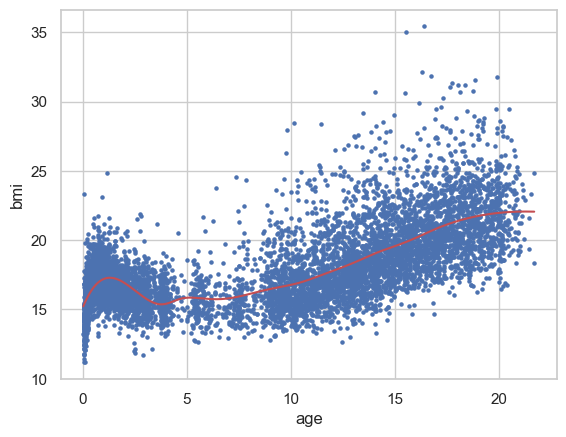

In [24]:
# plot the data
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(df["age"].to_numpy(), y, color = "r")
plt.show()

In [26]:
tau2 = q.trans_var_params["tau2"]["loc"]
s = q.trans_var_params["tau2"]["cov"]

In [27]:
tau2, s

(Array([-1.0979639], dtype=float32), Array([[0.09732933]], dtype=float32))

In [30]:
mean = jnp.exp(tau2 + s/2)

In [31]:
1 / mean

Array([[2.8556492]], dtype=float32)